<a href="https://colab.research.google.com/github/SunkaraboinaPraveenKumar/Machine_Learning_Projects/blob/main/Auto_Data_labeling_using_Florence_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import libraries

In [4]:
!pip install accelerate
!pip install flash_attn einops timm

In [5]:
import textwrap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
from transformers import AutoProcessor, AutoModelForCausalLM

# Import Florence-2 model

In [6]:
!pip install timm flash_attn

In [7]:
model_id = 'microsoft/Florence-2-large'
#model_id = 'microsoft/Florence-2-base'

model = AutoModelForCausalLM.from_pretrained(model_id,
                                             trust_remote_code=True).eval()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)




/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [8]:
def florence2(task_prompt,images, text_input=None):
    """
    Calling the Microsoft Florence2 model
    """
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input

    inputs = processor(text=prompt, images=image, return_tensors="pt")

    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids,
                                            skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height))

    return parsed_answer


# Object Detection

In [9]:
!unzip data.zip

Archive:  data.zip
replace data/1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/2.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/3.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/4.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/5.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [10]:
image = Image.open('/content/data/1.png')

task_prompt3 = '<OD>'
od_results = florence2(task_prompt3, image)
od_results['<OD>']

{'bboxes': [[152.66249084472656,
   5.737499713897705,
   217.6875,
   65.13749694824219],
  [7.087499618530273, 164.8125, 68.51249694824219, 214.53749084472656],
  [113.73749542236328, 60.63749694824219, 158.7375030517578, 101.8125],
  [9.5625, 111.71249389648438, 62.88749694824219, 138.2624969482422],
  [176.28749084472656, 131.96249389648438, 214.08749389648438, 167.0625],
  [70.76249694824219, 183.9375, 103.38749694824219, 214.3125],
  [12.262499809265137,
   133.7624969482422,
   57.037498474121094,
   160.08749389648438],
  [6.412499904632568,
   11.362499237060547,
   72.3375015258789,
   53.21249771118164]],
 'labels': ['flower',
  'flower',
  'flower',
  'flower',
  'flower',
  'flower',
  'flowerpot',
  'hat']}

In [11]:
def plot_bbox(image, data):
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

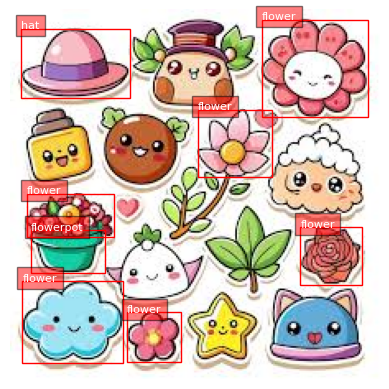

In [12]:
plot_bbox(image, od_results['<OD>']);

# Guided object detection

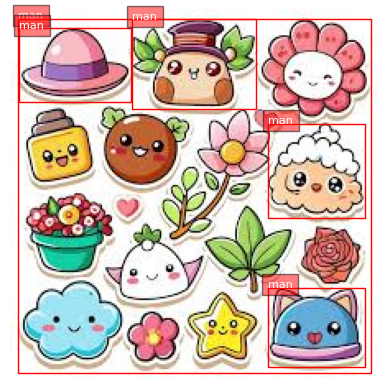

In [13]:
task_prompt4 = "<CAPTION_TO_PHRASE_GROUNDING>"

result = florence2(task_prompt4, image, text_input="man")

plot_bbox(image, result['<CAPTION_TO_PHRASE_GROUNDING>']);

# Auto Data labeling

In [14]:
def florence2(task_prompt, images, text_input=None):
    """
    Calling the Microsoft Florence2 model
    """
    results = []

    for image in images:
        if text_input is None:
            prompt = task_prompt
        else:
            prompt = task_prompt + text_input

        inputs = processor(text=prompt, images=image, return_tensors="pt")

        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            early_stopping=False,
            do_sample=False,
            num_beams=3,
        )
        generated_text = processor.batch_decode(generated_ids,
                                                skip_special_tokens=False)[0]
        parsed_answer = processor.post_process_generation(
            generated_text,
            task=task_prompt,
            image_size=(image.width, image.height))

        results.append(parsed_answer)

    return results



In [15]:
from PIL import Image
import os

def process_images(folder_path):
    # Get all image files in the folder
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]

    for image_path in image_files:
        image_name = os.path.basename(image_path)
        image_name_without_extension = os.path.splitext(image_name)[0]

        # Load image using PIL
        try:
            image = Image.open(image_path)
        except IOError:
            print(f'Failed to open image: {image_path}')
            continue

        # Define task_prompt3 (if it's constant for all images)
        task_prompt3 = '<OD>'

        # Call your function to get results
        od_results_list = florence2(task_prompt3, [image])

        # Iterate over each result in the list
        for idx, od_results in enumerate(od_results_list):
            # Save results to a text file with the same name as the image
            output_file_path = os.path.join(folder_path, f'{image_name_without_extension}_{idx}.txt')

            with open(output_file_path, 'w') as f:
                # Write the results to the text file
                for key, value in od_results['<OD>'].items():
                    f.write(f"{key}: {value}\n")

            print(f'Results for {image_name} (index {idx}) saved to {output_file_path}')


In [16]:
folder_path = '/content/data'
process_images(folder_path)

Results for 4.png (index 0) saved to /content/data/4_0.txt
Results for 1.png (index 0) saved to /content/data/1_0.txt
Results for 2.png (index 0) saved to /content/data/2_0.txt
Results for 5.png (index 0) saved to /content/data/5_0.txt
Results for 3.png (index 0) saved to /content/data/3_0.txt


# Convert to yolo format

In [17]:
import os
import json

def convert_to_yolo_format(bboxes, labels, image_width, image_height):
    yolo_annotations = []

    for bbox, label in zip(bboxes, labels):
        xmin, ymin, xmax, ymax = bbox

        # Calculate bounding box center and dimensions
        x_center = (xmin + xmax) / 2 / image_width
        y_center = (ymin + ymax) / 2 / image_height
        box_width = (xmax - xmin) / image_width
        box_height = (ymax - ymin) / image_height

        # Find the class index (you may need to adjust this based on your class mapping)
        class_index = get_class_index(label)

        # Append annotation in YOLO format
        yolo_annotations.append(f"{class_index} {x_center} {y_center} {box_width} {box_height}")

    return yolo_annotations

def get_class_index(label):
    # Define your class mapping here
    class_mapping = {
        'fish': 0,
        'reptile': 1,
        'elephant':2,
        'flower':3,
        'hat':4,
        'bird':5

        # Add more classes as needed
    }
    return class_mapping.get(label, -1)  # Return -1 if label not found

def process_images(folder_path):
    # Get all image files in the folder
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]

    for image_path in image_files:
        image_name = os.path.basename(image_path)
        image_name_without_extension = os.path.splitext(image_name)[0]

        # Load image using PIL
        try:
            image = Image.open(image_path)
            image_width, image_height = image.size
        except IOError:
            print(f'Failed to open image: {image_path}')
            continue

        # Call your function to get annotations
        od_results_list = florence2('<OD>', [image])

        # Iterate over each result in the list
        for idx, od_results in enumerate(od_results_list):
            bboxes = od_results['<OD>']['bboxes']
            labels = od_results['<OD>']['labels']

            # Convert annotations to YOLO format
            yolo_annotations = convert_to_yolo_format(bboxes, labels, image_width, image_height)

            # Save YOLO annotations to a text file
            output_file_path = os.path.join(folder_path, f'{image_name_without_extension}_{idx}.txt')

            with open(output_file_path, 'w') as f:
                for annotation in yolo_annotations:
                    f.write(annotation + '\n')

            print(f'Annotations for {image_name} (index {idx}) saved to {output_file_path}')


In [18]:
folder_path = '/content/data'
process_images(folder_path)

Annotations for 4.png (index 0) saved to /content/data/4_0.txt
Annotations for 1.png (index 0) saved to /content/data/1_0.txt
Annotations for 2.png (index 0) saved to /content/data/2_0.txt
Annotations for 5.png (index 0) saved to /content/data/5_0.txt
Annotations for 3.png (index 0) saved to /content/data/3_0.txt
